# Atlas Segmentation

This notebook demonstrates how to perform basic atlas-based segmentation using PlatiPy.

## Import Modules

The following cell imports the modules needed for this example.

In [1]:
# Check if platipy is installed, if not install it.
try:
    import platipy
except:
    !pip install platipy
    import platipy

# The ImageVisualiser class
from platipy.imaging import ImageVisualiser

# Function to grab some test data
from platipy.imaging.tests.data import get_lung_nifti

# Usual suspects
import numpy as np
import SimpleITK as sitk
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# The platipy functions we'll be using in this example
from platipy.imaging.projects.multiatlas.run import run_segmentation, MUTLIATLAS_SETTINGS_DEFAULTS
from platipy.imaging.registration.deformable import fast_symmetric_forces_demons_registration
from platipy.imaging.registration.utils import apply_transform
from platipy.imaging.registration.linear import linear_registration
from platipy.imaging.visualisation.comparison import contour_comparison

## Download Test Data

Some Lung test data from LCTSC is fetched here for use in this example notebook.

In [2]:
input_directory = get_lung_nifti()

## Single Atlas Segmentation

Here we will define one test case and one atlas case to perform single atlas segmentation.

In [3]:
atlas_case = "LCTSC-Test-S1-101"
test_case = "LCTSC-Test-S1-201"

### Read data

Let's load the images and contours for our test and atlas case

In [4]:
def read_image_and_contours(case_id):

    pat_directory = input_directory.joinpath(case_id)

    # Read in the CT image
    ct_filename = next(pat_directory.glob("**/IMAGES/*.nii.gz"))
    ct_image = sitk.ReadImage(ct_filename.as_posix())

    # Read in the RTStruct contours as binary masks
    contour_filename_list = list(pat_directory.glob("**/STRUCTURES/*.nii.gz"))

    contours = {}
    for contour_filename in contour_filename_list:
        _name = contour_filename.name.split(".nii.gz")[0].split("RTSTRUCT_")[-1]
        
        contours[_name] = sitk.ReadImage(contour_filename.as_posix())

    return ct_image, contours

img_ct_test, contours_test = read_image_and_contours(test_case)
img_ct_atlas, contours_atlas = read_image_and_contours(atlas_case)

### Visualise data

Now we'll prepare some figures to view this data.

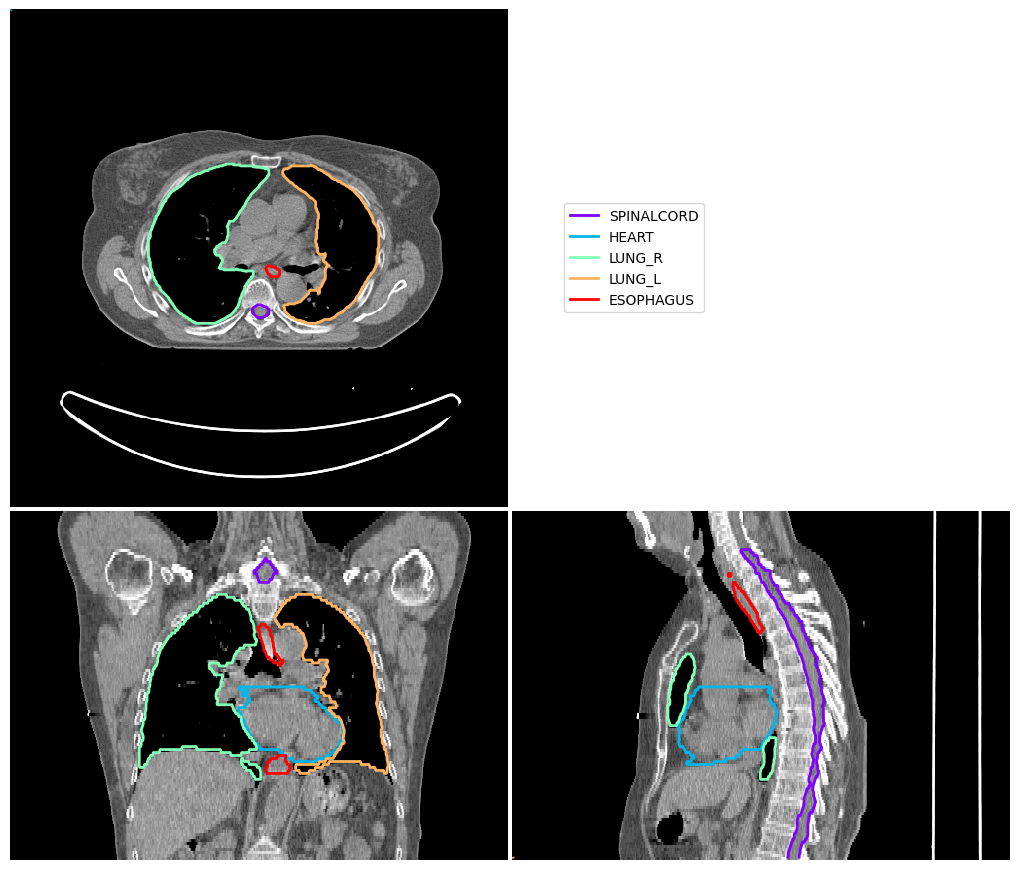

In [5]:
vis = ImageVisualiser(img_ct_test)
vis.add_contour(contours_test)
fig = vis.show()

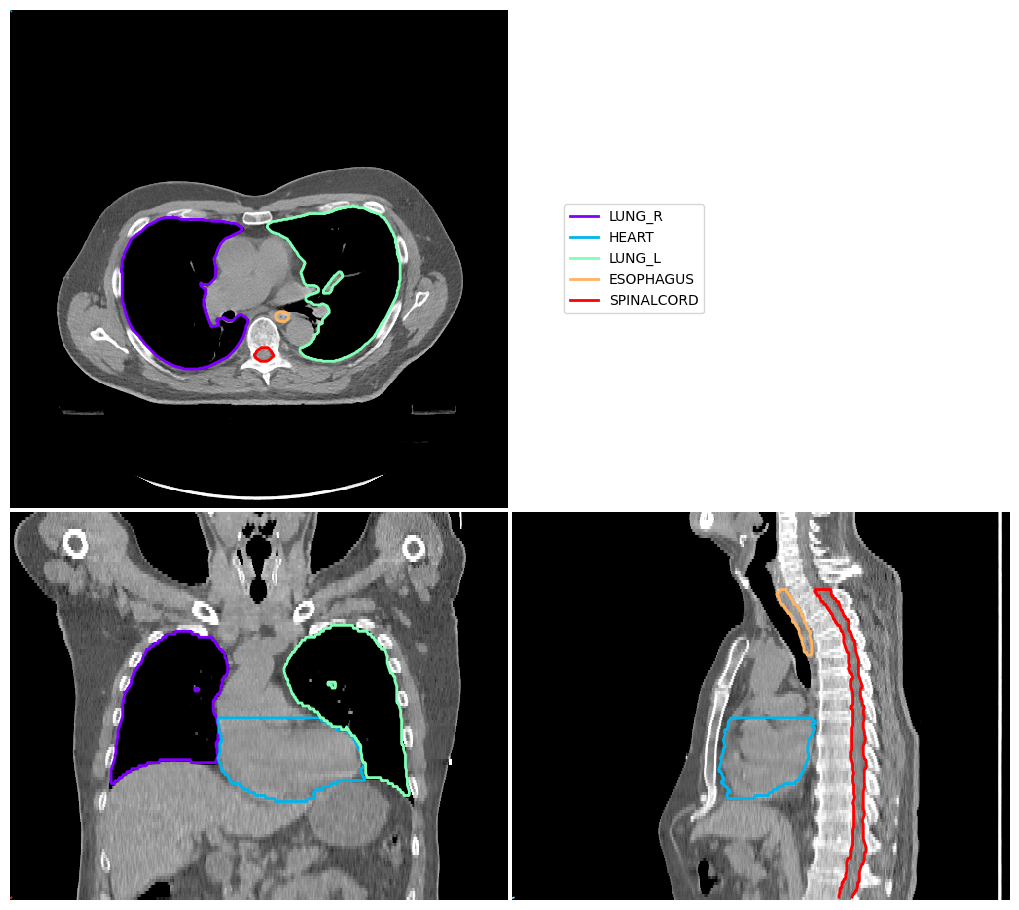

In [6]:
vis = ImageVisualiser(img_ct_atlas)
vis.add_contour(contours_atlas)
fig = vis.show()

### Linear (Rigid) Registration

Next we perform a linear registration, setting our test image as the fixed image and aligning our
atlas image to it. The aligned image is the visualised by overlaying it with the test image to
help visually inspect the quality of the registration.

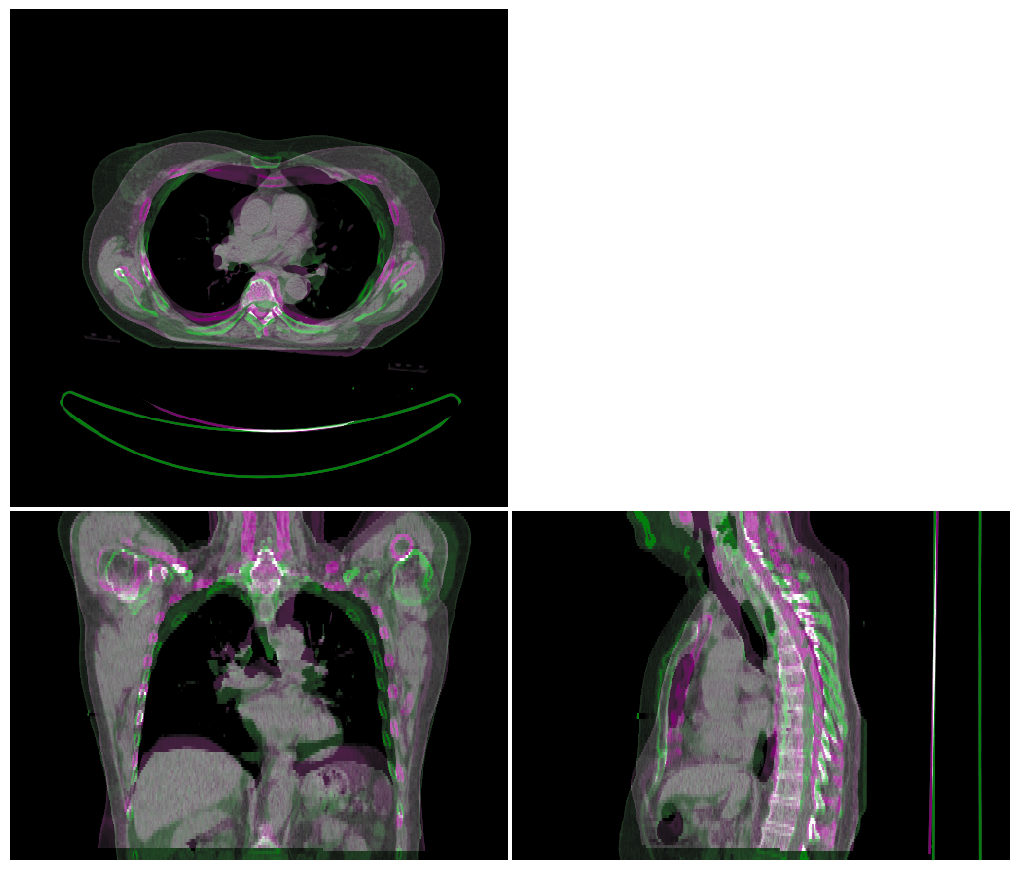

In [7]:
img_ct_atlas_reg_linear, tfm_linear = linear_registration(
    fixed_image = img_ct_test,
    moving_image = img_ct_atlas,
    reg_method='similarity',
    metric='mean_squares',
    optimiser='gradient_descent',
    shrink_factors=[8, 4, 2],
    smooth_sigmas=[4, 2, 0],
    sampling_rate=1.0,
    number_of_iterations=50,
)

vis = ImageVisualiser(img_ct_test)
vis.add_comparison_overlay(img_ct_atlas_reg_linear)
fig = vis.show()

### Deformable Registration

Assuming the linear registration went well, we now us deformable image registration to better align
the atlas image to the test image. Again the resulting alignment is visualised.

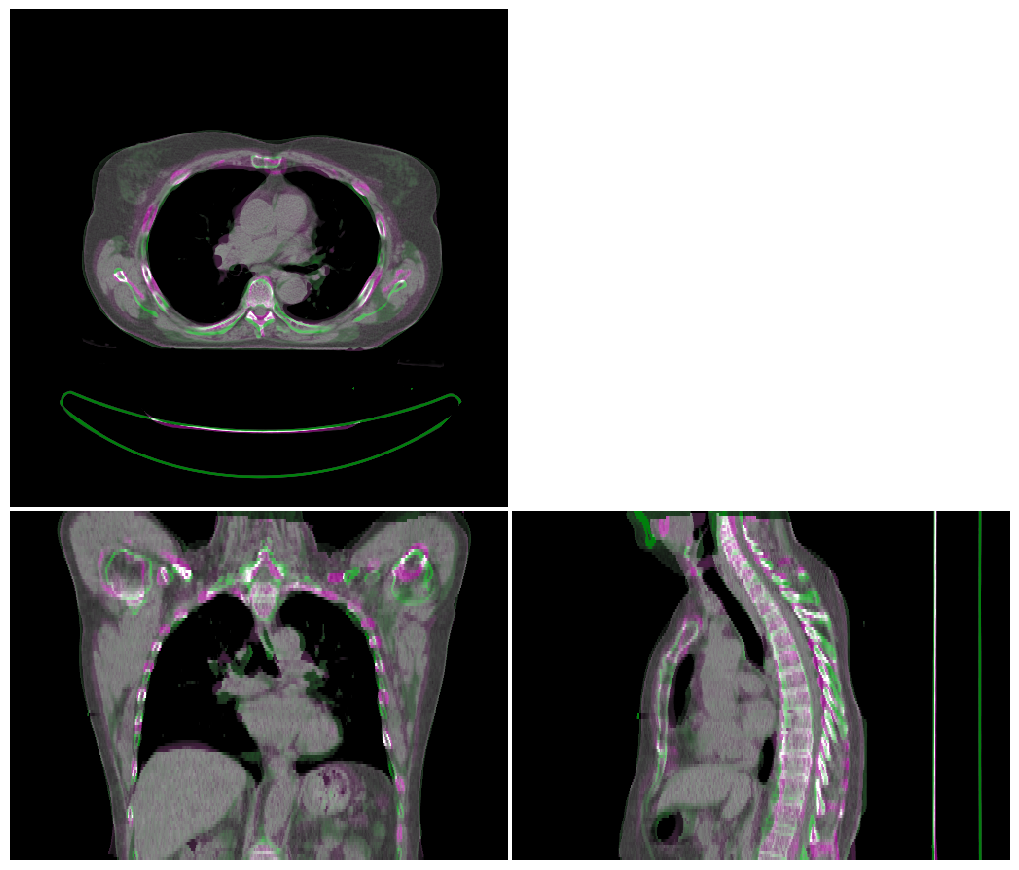

In [8]:

img_ct_atlas_reg_dir, tfm_dir, dvf = fast_symmetric_forces_demons_registration(
    img_ct_test,
    img_ct_atlas_reg_linear,
    ncores=4,
    isotropic_resample=True,
    resolution_staging=[8],
    iteration_staging=[20],
)

vis = ImageVisualiser(img_ct_test)
vis.add_comparison_overlay(img_ct_atlas_reg_dir)
fig = vis.show()

### Propagate Contours

Now that our images are aligned, we can combined the linear and the deformable registration and use
this to propagate the contours from our atlas image to our test image.

In [9]:
tfm_combined = sitk.CompositeTransform((tfm_linear, tfm_dir))

# apply to the contours
contours_atlas_reg_dir = {}
for s in contours_atlas:
  contours_atlas_reg_dir[s] = apply_transform(
      contours_atlas[s],
      reference_image=img_ct_test,
      transform=tfm_combined
    )

### Contour Comparison

Then we can compare our automatically generated (propagated) contours with our ground truth
(manual) contours on our test case. To to this we use platipy's built-in `contour_comparison`
function. This produces a visualisation was well as a pandas DataFrame with the quantitative
metrics.

,STRUCTURE,DSC,MDA_mm,HD_mm,VOL_MANUAL_cm3,VOL_AUTOMATIC_cm3
0,SPINALCORD,0.598321,4.335056,44.031540,54.210663,36.126137
0,HEART,0.840562,5.196209,18.599574,759.281158,570.653915
0,LUNG_R,0.921319,1.836401,13.494053,1424.428940,1422.554970
0,LUNG_L,0.894427,1.914315,18.131971,1015.133858,1056.069374
0,ESOPHAGUS,0.423633,2.989856,12.844674,27.577400,23.898125


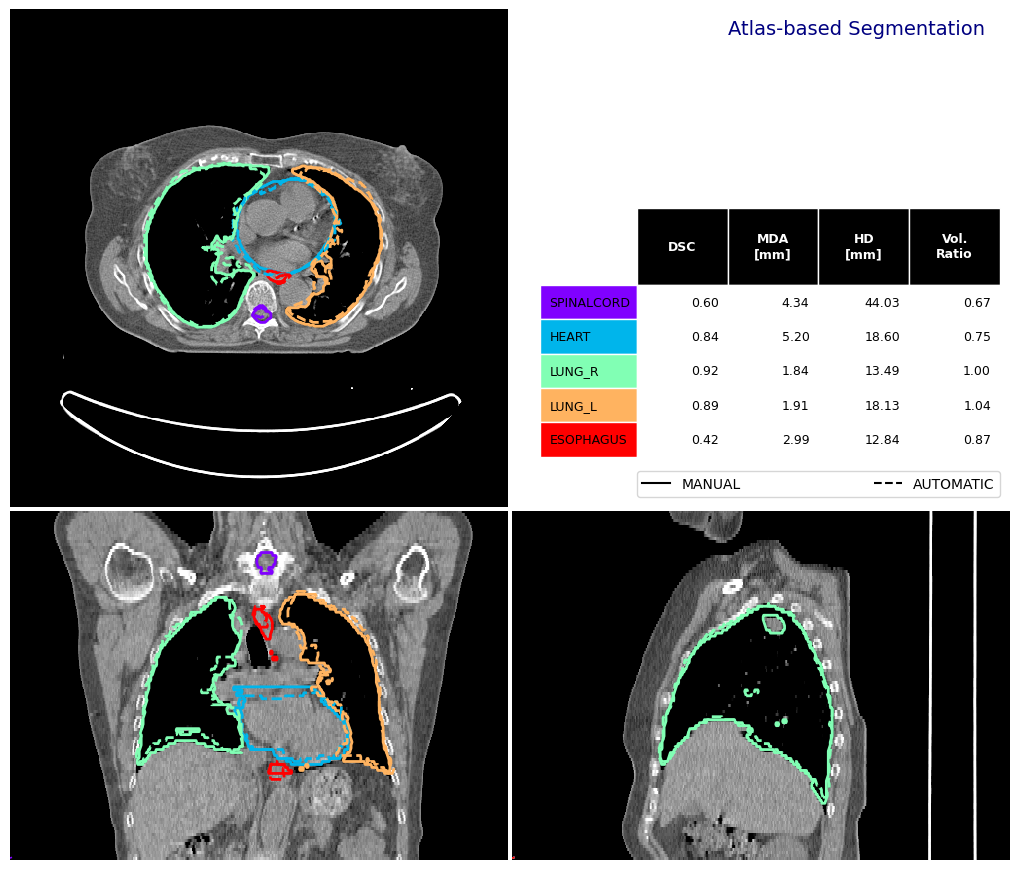

In [10]:
fig, df_sas = contour_comparison(
    img = img_ct_test,
    contour_dict_a = contours_test,
    contour_dict_b = contours_atlas_reg_dir,
    contour_label_a = "MANUAL",
    contour_label_b = "AUTOMATIC",
    title='Atlas-based Segmentation',
    subtitle='',
    subsubtitle='',
)

df_sas

## Multi-atlas Segmentation

We can often improve the quality of atlas-based segmentation by using multiple atlas cases. PlatiPy
has built-in functionality to perform multi-atlas segmentation. The following example uses 4 atlas
cases to auto-segment our test case.

In [11]:
# make a copy of the default settings
user_settings = MUTLIATLAS_SETTINGS_DEFAULTS

# Define the list of structures we are segmenting
structure_list = [
    "LUNG_L",
    "LUNG_R",
    "HEART",
    "SPINALCORD",
    "ESOPHAGUS",
]

# Define the atlas set
atlas_set = ["101", "102", "103", "104"]

user_settings['atlas_settings'] = {
    'atlas_id_list': atlas_set,
    'atlas_structure_list': structure_list,
    'atlas_path': './data/nifti/lung',
    'atlas_image_format': 'LCTSC-Test-S1-{0}/IMAGES/LCTSC_TEST_S1_{0}_0_CT_0.nii.gz',
    'atlas_label_format': 'LCTSC-Test-S1-{0}/STRUCTURES/LCTSC_TEST_S1_{0}_0_RTSTRUCT_{1}.nii.gz',
    'crop_atlas_to_structures': True,
    'crop_atlas_expansion_mm': 10,
}

# optionally, we can change some of the default registration parameters
user_settings["linear_registration_settings"] = {
    "reg_method": "similarity",
    "shrink_factors": [8, 4, 2],
    "smooth_sigmas": [4, 2, 0],
    "sampling_rate": 1,
    "default_value": -1000,
    "number_of_iterations": 50,
    "metric": "mean_squares",
    "optimiser": "gradient_descent",
    "verbose": False
}

user_settings["deformable_registration_settings"] = {
    "isotropic_resample": True,
    "resolution_staging": [8],
    "iteration_staging": [20],
    # Try commenting out the two lines above and uncommenting the following two lines for a better
    # DIR (but slower runtime)
    # "resolution_staging": [8,4,2],
    # "iteration_staging": [50,50,25],
    "smoothing_sigmas": [4,2,0],
    "ncores": 32,
    "default_value": -1000,
    "verbose": False
}

# Perform the multi-atlas segmentation
output_contours, output_probability = run_segmentation(img_ct_test, user_settings)

### Contour Comparison

Now let's analyse the performance of the multi-atlas segmentation.

,STRUCTURE,DSC,MDA_mm,HD_mm,VOL_MANUAL_cm3,VOL_AUTOMATIC_cm3
0,SPINALCORD,0.680778,1.802686,15.625000,54.210663,42.028427
0,HEART,0.893231,3.805641,22.395659,759.281158,759.026527
0,LUNG_R,0.906017,2.291072,18.599574,1424.428940,1535.373688
0,LUNG_L,0.902691,1.743637,14.648438,1015.133858,1135.399818
0,ESOPHAGUS,0.444920,3.311902,18.929921,27.577400,17.924309


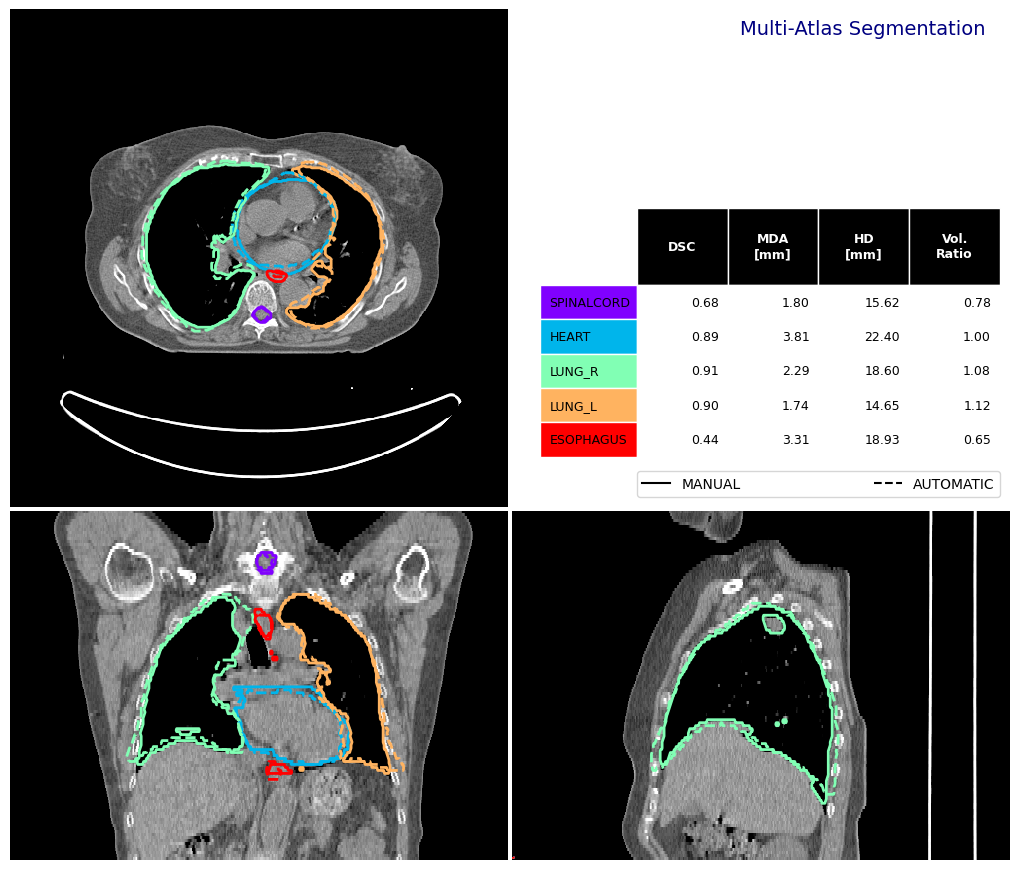

In [12]:
fig, df_mas = contour_comparison(
    img = img_ct_test,
    contour_dict_a = contours_test,
    contour_dict_b = output_contours,
    contour_label_a = "MANUAL",
    contour_label_b = "AUTOMATIC",
    title='Multi-Atlas Segmentation',
    subtitle='',
    subsubtitle='',
)

df_mas

## Single-atlas vs Multi-atlas

Finally, we'll compare how the two approaches performed for each of our structures.

In [13]:
df_combined = pd.merge(
    left = df_sas,
    right = df_mas,
    on = "STRUCTURE",
    suffixes = [" (single)", " (multi)"]
)

df_combined[["STRUCTURE","DSC (single)", "DSC (multi)"]]

,STRUCTURE,DSC (single),DSC (multi)
0,SPINALCORD,0.598321,0.680778
1,HEART,0.840562,0.893231
2,LUNG_R,0.921319,0.906017
3,LUNG_L,0.894427,0.902691
4,ESOPHAGUS,0.423633,0.444920
